## This Notebook has the model definitions that works with verifiers - removes Transpose Convs, Log softmax, uses only ReLUs etc.

In [1]:


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms as tr
from torchinfo import summary

# Other
import os
import numpy as np
import random
from skimage import io
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm as tqdm
from pandas import read_csv
from math import floor, ceil, sqrt, exp
from IPython import display
import time
from itertools import chain
import time
import warnings
from pprint import pprint

from numpy.random import RandomState

SEED=2342

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
print('IMPORTS OK')

# Global Variables' Definitions

PATH_TO_DATASET = './OSCD/'
IS_PROTOTYPE = False

FP_MODIFIER = 10 # Tuning parameter, use 1 if unsure
#BATCH_SIZE = 32
BATCH_SIZE = 8
#BATCH_SIZE = 1

PATCH_SIDE = 128
N_EPOCHS = 30
NORMALISE_IMGS = True
TRAIN_STRIDE = int(PATCH_SIDE/2) - 1
TYPE = 3 # 0-RGB | 1-RGBIr | 2-All bands s.t. resulution <= 20m | 3-All bands
LOAD_TRAINED = False
DATA_AUG = True
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device = torch.device("cpu") 

print('DEFINITIONS OK')

# Dataset Functions

def adjust_shape(I, s):
    """Adjust shape of grayscale image I to s."""
    
    # crop if necesary
    I = I[:s[0],:s[1]]
    si = I.shape
    
    # pad if necessary 
    p0 = max(0,s[0] - si[0])
    p1 = max(0,s[1] - si[1])
    
    return np.pad(I,((0,p0),(0,p1)),'edge')
    

def read_sentinel_img(path):
    """Read cropped Sentinel-2 image: RGB bands."""
    im_name = os.listdir(path)[0][:-7]
    r = io.imread(path + im_name + "B04.tif")
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    
    I = np.stack((r,g,b),axis=2).astype('float')
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_4(path):
    """Read cropped Sentinel-2 image: RGB and NIR bands."""
    im_name = os.listdir(path)[0][:-7]
    r = io.imread(path + im_name + "B04.tif")
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")
    
    I = np.stack((r,g,b,nir),axis=2).astype('float')
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_leq20(path):
    """Read cropped Sentinel-2 image: bands with resolution less than or equals to 20m."""
    im_name = os.listdir(path)[0][:-7]
    
    r = io.imread(path + im_name + "B04.tif")
    s = r.shape
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")
    
    ir1 = adjust_shape(zoom(io.imread(path + im_name + "B05.tif"),2),s)
    ir2 = adjust_shape(zoom(io.imread(path + im_name + "B06.tif"),2),s)
    ir3 = adjust_shape(zoom(io.imread(path + im_name + "B07.tif"),2),s)
    nir2 = adjust_shape(zoom(io.imread(path + im_name + "B8A.tif"),2),s)
    swir2 = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)
    swir3 = adjust_shape(zoom(io.imread(path + im_name + "B12.tif"),2),s)
    
    I = np.stack((r,g,b,nir,ir1,ir2,ir3,nir2,swir2,swir3),axis=2).astype('float')
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_leq60(path):
    """Read cropped Sentinel-2 image: all bands."""
    im_name = os.listdir(path)[0][:-7]
    
    r = io.imread(path + im_name + "B04.tif")
    s = r.shape
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")
    
    ir1 = adjust_shape(zoom(io.imread(path + im_name + "B05.tif"),2),s)
    ir2 = adjust_shape(zoom(io.imread(path + im_name + "B06.tif"),2),s)
    ir3 = adjust_shape(zoom(io.imread(path + im_name + "B07.tif"),2),s)
    nir2 = adjust_shape(zoom(io.imread(path + im_name + "B8A.tif"),2),s)
    swir2 = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)
    swir3 = adjust_shape(zoom(io.imread(path + im_name + "B12.tif"),2),s)
    
    uv = adjust_shape(zoom(io.imread(path + im_name + "B01.tif"),6),s)
    wv = adjust_shape(zoom(io.imread(path + im_name + "B09.tif"),6),s)
    swirc = adjust_shape(zoom(io.imread(path + im_name + "B10.tif"),6),s)
    
    I = np.stack((r,g,b,nir,ir1,ir2,ir3,nir2,swir2,swir3,uv,wv,swirc),axis=2).astype('float')
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_trio(path):
    """Read cropped Sentinel-2 image pair and change map."""
#     read images
    if TYPE == 0:
        I1 = read_sentinel_img(path + '/imgs_1/')
        I2 = read_sentinel_img(path + '/imgs_2/')
    elif TYPE == 1:
        I1 = read_sentinel_img_4(path + '/imgs_1/')
        I2 = read_sentinel_img_4(path + '/imgs_2/')
    elif TYPE == 2:
        I1 = read_sentinel_img_leq20(path + '/imgs_1/')
        I2 = read_sentinel_img_leq20(path + '/imgs_2/')
    elif TYPE == 3:
        I1 = read_sentinel_img_leq60(path + '/imgs_1/')
        I2 = read_sentinel_img_leq60(path + '/imgs_2/')
        
    cm = io.imread(path + '/cm/cm.png', as_gray=True) != 0
    
    # crop if necessary
    s1 = I1.shape
    s2 = I2.shape
    I2 = np.pad(I2,((0, s1[0] - s2[0]), (0, s1[1] - s2[1]), (0,0)),'edge')
    
    
    return I1, I2, cm



def reshape_for_torch(I):
    """Transpose image for PyTorch coordinates."""
#     out = np.swapaxes(I,1,2)
#     out = np.swapaxes(out,0,1)
#     out = out[np.newaxis,:]
    out = I.transpose((2, 0, 1))
    return torch.from_numpy(out)



class ChangeDetectionDataset(Dataset):
    """Change Detection dataset class, used for both training and test data."""

    def __init__(self, path, train = True, patch_side = 128, stride = None, use_all_bands = False, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        # basics
        self.transform = transform
        self.path = path
        self.patch_side = patch_side
        if not stride:
            self.stride = 1
        else:
            self.stride = stride
        
        if train:
            fname = 'train.txt'
        else:
            fname = 'test.txt'
        
#         print(path + fname)
        self.names = read_csv(path + fname).columns
        self.n_imgs = self.names.shape[0]
        
        n_pix = 0
        true_pix = 0
        
        
        # load images
        self.imgs_1 = {}
        self.imgs_2 = {}
        self.change_maps = {}
        self.n_patches_per_image = {}
        self.n_patches = 0
        self.patch_coords = []
        for im_name in tqdm(self.names):
            # load and store each image
            I1, I2, cm = read_sentinel_img_trio(self.path + im_name)
            self.imgs_1[im_name] = reshape_for_torch(I1)
            self.imgs_2[im_name] = reshape_for_torch(I2)
            self.change_maps[im_name] = cm
            
            s = cm.shape
            n_pix += np.prod(s)
            true_pix += cm.sum()
            
            # calculate the number of patches
            s = self.imgs_1[im_name].shape
            n1 = ceil((s[1] - self.patch_side + 1) / self.stride)
            n2 = ceil((s[2] - self.patch_side + 1) / self.stride)
            n_patches_i = n1 * n2
            self.n_patches_per_image[im_name] = n_patches_i
            self.n_patches += n_patches_i
            
            # generate path coordinates
            for i in range(n1):
                for j in range(n2):
                    # coordinates in (x1, x2, y1, y2)
                    current_patch_coords = (im_name, 
                                    [self.stride*i, self.stride*i + self.patch_side, self.stride*j, self.stride*j + self.patch_side],
                                    [self.stride*(i + 1), self.stride*(j + 1)])
                    self.patch_coords.append(current_patch_coords)
                    
        self.weights = [ FP_MODIFIER * 2 * true_pix / n_pix, 2 * (n_pix - true_pix) / n_pix]
        
    def get_img(self, im_name):
        return self.imgs_1[im_name], self.imgs_2[im_name], self.change_maps[im_name]        

    def get_ood_img(self, im_name):
        return self.transform(self.imgs_1[im_name]).squeeze(0), self.transform(self.imgs_2[im_name]).squeeze(0), self.change_maps[im_name]
        
    def __len__(self):
        return self.n_patches

    def __getitem__(self, idx):
        current_patch_coords = self.patch_coords[idx]
        im_name = current_patch_coords[0]
        limits = current_patch_coords[1]
        centre = current_patch_coords[2]
        
        I1 = self.imgs_1[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
        I2 = self.imgs_2[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
        
        label = self.change_maps[im_name][limits[0]:limits[1], limits[2]:limits[3]]
        label = torch.from_numpy(1*np.array(label)).float()
        
        sample = {'I1': I1, 'I2': I2, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)

        return sample



class RandomFlip(object):
    """Flip randomly the images in a sample."""

#     def __init__(self):
#         return

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']
        
        if random.random() > 0.5:
            I1 =  I1.numpy()[:,:,::-1].copy()
            I1 = torch.from_numpy(I1)
            I2 =  I2.numpy()[:,:,::-1].copy()
            I2 = torch.from_numpy(I2)
            label =  label.numpy()[:,::-1].copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}



class RandomRot(object):
    """Rotate randomly the images in a sample."""

#     def __init__(self):
#         return

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']
        
        n = random.randint(0, 3)
        if n:
            I1 =  sample['I1'].numpy()
            I1 = np.rot90(I1, n, axes=(1, 2)).copy()
            I1 = torch.from_numpy(I1)
            I2 =  sample['I2'].numpy()
            I2 = np.rot90(I2, n, axes=(1, 2)).copy()
            I2 = torch.from_numpy(I2)
            label =  sample['label'].numpy()
            label = np.rot90(label, n, axes=(0, 1)).copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}

print('UTILS OK')

# Training functions
def train(model, net_name, criterion, optimizer, scheduler, feat=False, n_epochs = N_EPOCHS, save = True):
    L = 1024
    N = 2
    t = np.linspace(1, n_epochs, n_epochs)
    
    epoch_train_loss = 0 * t
    epoch_train_accuracy = 0 * t
    epoch_train_change_accuracy = 0 * t
    epoch_train_nochange_accuracy = 0 * t
    epoch_train_precision = 0 * t
    epoch_train_recall = 0 * t
    epoch_train_Fmeasure = 0 * t
    epoch_test_loss = 0 * t
    epoch_test_accuracy = 0 * t
    epoch_test_change_accuracy = 0 * t
    epoch_test_nochange_accuracy = 0 * t
    epoch_test_precision = 0 * t
    epoch_test_recall = 0 * t
    epoch_test_Fmeasure = 0 * t
    
    
#     mean_acc = 0
#     best_mean_acc = 0
    fm = 0
    best_fm = 0
    
    lss = 1000
    best_lss = 1000
    
    plt.figure(num=1)
    plt.figure(num=2)
    plt.figure(num=3)
    
    for epoch_index in tqdm(range(n_epochs)):
        model.train()
        print('Epoch: ' + str(epoch_index + 1) + ' of ' + str(N_EPOCHS))

        tot_count = 0
        tot_loss = 0
        tot_accurate = 0
        class_correct = list(0. for i in range(2))
        class_total = list(0. for i in range(2))
#         for batch_index, batch in enumerate(tqdm(data_loader)):
        for batch in train_loader:
            I1 = Variable(batch['I1'].float().to(device))
            #I1 = Variable(batch['I1'].float())
            #I2 = Variable(batch['I2'].float())
            I2 = Variable(batch['I2'].float().to(device))
            #I2 = Variable(batch['I2'].float())
            #label = torch.squeeze(Variable(batch['label'].cuda()))
            label = torch.squeeze(Variable(batch['label'].to(device)))

            optimizer.zero_grad()
            if feat:
                output, _ = model(I1, I2)
            else:
                output = model(I1, I2)
            loss = criterion(output, label.long())
            loss.backward()
            optimizer.step()
            
        scheduler.step()


        epoch_train_loss[epoch_index], epoch_train_accuracy[epoch_index], cl_acc, pr_rec = test(train_dataset, criterion, model, feat=feat)
        epoch_train_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_train_change_accuracy[epoch_index] = cl_acc[1]
        epoch_train_precision[epoch_index] = pr_rec[0]
        epoch_train_recall[epoch_index] = pr_rec[1]
        epoch_train_Fmeasure[epoch_index] = pr_rec[2]
        
        epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test(test_dataset, criterion, model, feat=feat)
        epoch_test_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_test_change_accuracy[epoch_index] = cl_acc[1]
        epoch_test_precision[epoch_index] = pr_rec[0]
        epoch_test_recall[epoch_index] = pr_rec[1]
        epoch_test_Fmeasure[epoch_index] = pr_rec[2]

        plt.figure(num=1)
        plt.clf()
        l1_1, = plt.plot(t[:epoch_index + 1], epoch_train_loss[:epoch_index + 1], label='Train loss')
        l1_2, = plt.plot(t[:epoch_index + 1], epoch_test_loss[:epoch_index + 1], label='Test loss')
        plt.legend(handles=[l1_1, l1_2])
        plt.grid()
#         plt.gcf().gca().set_ylim(bottom = 0)
        plt.gcf().gca().set_xlim(left = 0)
        plt.title('Loss')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=2)
        plt.clf()
        l2_1, = plt.plot(t[:epoch_index + 1], epoch_train_accuracy[:epoch_index + 1], label='Train accuracy')
        l2_2, = plt.plot(t[:epoch_index + 1], epoch_test_accuracy[:epoch_index + 1], label='Test accuracy')
        plt.legend(handles=[l2_1, l2_2])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=3)
        plt.clf()
        l3_1, = plt.plot(t[:epoch_index + 1], epoch_train_nochange_accuracy[:epoch_index + 1], label='Train accuracy: no change')
        l3_2, = plt.plot(t[:epoch_index + 1], epoch_train_change_accuracy[:epoch_index + 1], label='Train accuracy: change')
        l3_3, = plt.plot(t[:epoch_index + 1], epoch_test_nochange_accuracy[:epoch_index + 1], label='Test accuracy: no change')
        l3_4, = plt.plot(t[:epoch_index + 1], epoch_test_change_accuracy[:epoch_index + 1], label='Test accuracy: change')
        plt.legend(handles=[l3_1, l3_2, l3_3, l3_4])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy per class')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=4)
        plt.clf()
        l4_1, = plt.plot(t[:epoch_index + 1], epoch_train_precision[:epoch_index + 1], linewidth = '1', label='Train precision')
        l4_2, = plt.plot(t[:epoch_index + 1], epoch_train_recall[:epoch_index + 1],  linewidth = '1', label='Train recall')
        l4_3, = plt.plot(t[:epoch_index + 1], epoch_train_Fmeasure[:epoch_index + 1],  linewidth = '1', label='Train Dice/F1')
        l4_4, = plt.plot(t[:epoch_index + 1], epoch_test_precision[:epoch_index + 1],  linestyle='dashed', linewidth = '2', label='Test precision')
        l4_5, = plt.plot(t[:epoch_index + 1], epoch_test_recall[:epoch_index + 1], linestyle='dashed', linewidth = '2', label='Test recall')
        l4_6, = plt.plot(t[:epoch_index + 1], epoch_test_Fmeasure[:epoch_index + 1], linestyle='dashed', linewidth = '2', label='Test Dice/F1')
        plt.legend(handles=[l4_1, l4_2, l4_3, l4_4, l4_5, l4_6])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 1)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Precision, Recall and F-measure')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        
        
        
#         fm = pr_rec[2]
        fm = epoch_train_Fmeasure[epoch_index]
        if fm > best_fm:
            best_fm = fm
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_fm-' + str(fm) + '.pth.tar'
            torch.save(model.state_dict(), save_str)
        
        lss = epoch_train_loss[epoch_index]
        if lss < best_lss:
            best_lss = lss
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_loss-' + str(lss) + '.pth.tar'
            torch.save(model.state_dict(), save_str)
            
            
#         print('Epoch loss: ' + str(tot_loss/tot_count))
        if save:
            im_format = 'png'
    #         im_format = 'eps'

            plt.figure(num=1)
            plt.savefig(net_name + '-01-loss.' + im_format)

            plt.figure(num=2)
            plt.savefig(net_name + '-02-accuracy.' + im_format)

            plt.figure(num=3)
            plt.savefig(net_name + '-03-accuracy-per-class.' + im_format)

            plt.figure(num=4)
            plt.savefig(net_name + '-04-prec-rec-fmeas.' + im_format)
        
    out = {'train_loss': epoch_train_loss[-1],
           'train_accuracy': epoch_train_accuracy[-1],
           'train_nochange_accuracy': epoch_train_nochange_accuracy[-1],
           'train_change_accuracy': epoch_train_change_accuracy[-1],
           'test_loss': epoch_test_loss[-1],
           'test_accuracy': epoch_test_accuracy[-1],
           'test_nochange_accuracy': epoch_test_nochange_accuracy[-1],
           'test_change_accuracy': epoch_test_change_accuracy[-1]}
    
    print('pr_c, rec_c, f_meas, pr_nc, rec_nc')
    print(pr_rec)
    
    return out


def kappa(tp, tn, fp, fn):
    N = tp + tn + fp + fn
    p0 = (tp + tn) / N
    pe = ((tp+fp)*(tp+fn) + (tn+fp)*(tn+fn)) / (N * N)
    
    return (p0 - pe) / (1 - pe)

def test_patch_batch(dset, criterion, model, feat=False, batch_size=BATCH_SIZE, patch_size=PATCH_SIDE):
    L = 1024
    N = 2
    model.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    model = model.to(device)
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for img_index in dset.names:
        I1_full, I2_full, cm_full = dset.get_img(img_index)
        full_x, full_y = cm_full.shape
        cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm_full),0).float().to(device))
        cm_patch, cm_x, cm_y, cm_px, cm_py = get_mask_patch_batch(cm_full)
        I1_patch, i_x, i_y, i_px, i_py = get_image_patch_batch(I1_full)
        I2_patch, _, _, _, _ = get_image_patch_batch(I2_full)
        
        # first perform inference
        I1 = Variable(I1_patch.float().to(device))
        I2 = Variable(I2_patch.float().to(device))
        if feat:
            output, _ = model(I1, I2)
        else:
            output = model(I1, I2)
        #print(output.shape)
        output_size = (cm_px,cm_py)
        b_s =  1
        cm_recon = reconstruct_image_batch(output, b_s, output_size, patch_size)
        #print(cm_recon.shape)
        output = cm_recon[:, :, :full_x, :full_y]
        #print(output.shape)
        loss = criterion(output, cm.long())
        tot_loss += loss.data * np.prod(cm.size())
        tot_count += np.prod(cm.size())

        predicted = output.argmax(dim=1)  # Shape: (N, H, W)

        c = (predicted.int() == cm.data.int())
        for i in range(c.size(1)):
            for j in range(c.size(2)):
                l = int(cm.data[0, i, j])
                class_correct[l] += c[0, i, j]
                class_total[l] += 1
                
        pr = (predicted.int() > 0).cpu().numpy()
        gt = (cm.data.int() > 0).cpu().numpy()
        
        tp += np.logical_and(pr, gt).sum()
        tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
        fp += np.logical_and(pr, np.logical_not(gt)).sum()
        fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    net_loss = tot_loss/tot_count        
    net_loss = float(net_loss.cpu().numpy())
    
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
        class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)


    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, f_meas, prec_nc, rec_nc]
        
    return net_loss, net_accuracy, class_accuracy, pr_rec



def train_batch(model, net_name, criterion, optimizer, scheduler, feat=False, n_epochs = N_EPOCHS, save = True):
    L = 1024
    N = 2
    t = np.linspace(1, n_epochs, n_epochs)
    
    epoch_train_loss = 0 * t
    epoch_train_accuracy = 0 * t
    epoch_train_change_accuracy = 0 * t
    epoch_train_nochange_accuracy = 0 * t
    epoch_train_precision = 0 * t
    epoch_train_recall = 0 * t
    epoch_train_Fmeasure = 0 * t
    epoch_test_loss = 0 * t
    epoch_test_accuracy = 0 * t
    epoch_test_change_accuracy = 0 * t
    epoch_test_nochange_accuracy = 0 * t
    epoch_test_precision = 0 * t
    epoch_test_recall = 0 * t
    epoch_test_Fmeasure = 0 * t
    
    
#     mean_acc = 0
#     best_mean_acc = 0
    fm = 0
    best_fm = 0
    
    lss = 1000
    best_lss = 1000
    
    plt.figure(num=1)
    plt.figure(num=2)
    plt.figure(num=3)
    
    for epoch_index in tqdm(range(n_epochs)):
        model.train()
        print('Epoch: ' + str(epoch_index + 1) + ' of ' + str(N_EPOCHS))

        tot_count = 0
        tot_loss = 0
        tot_accurate = 0
        class_correct = list(0. for i in range(2))
        class_total = list(0. for i in range(2))
#         for batch_index, batch in enumerate(tqdm(data_loader)):
        for batch in train_loader:
            I1 = Variable(batch['I1'].float().to(device))
            #I1 = Variable(batch['I1'].float())
            #I2 = Variable(batch['I2'].float())
            I2 = Variable(batch['I2'].float().to(device))
            #I2 = Variable(batch['I2'].float())
            #label = torch.squeeze(Variable(batch['label'].cuda()))
            label = torch.squeeze(Variable(batch['label'].to(device)))

            optimizer.zero_grad()
            if feat:
                output, _ = model(I1, I2)
            else:
                output = model(I1, I2)
            loss = criterion(output, label.long())
            loss.backward()
            optimizer.step()
            
        scheduler.step()


        epoch_train_loss[epoch_index], epoch_train_accuracy[epoch_index], cl_acc, pr_rec = test_patch_batch(train_dataset, criterion, model, feat=feat)
        epoch_train_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_train_change_accuracy[epoch_index] = cl_acc[1]
        epoch_train_precision[epoch_index] = pr_rec[0]
        epoch_train_recall[epoch_index] = pr_rec[1]
        epoch_train_Fmeasure[epoch_index] = pr_rec[2]
        
        epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test_patch_batch(test_dataset, criterion, model, feat=feat)
        epoch_test_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_test_change_accuracy[epoch_index] = cl_acc[1]
        epoch_test_precision[epoch_index] = pr_rec[0]
        epoch_test_recall[epoch_index] = pr_rec[1]
        epoch_test_Fmeasure[epoch_index] = pr_rec[2]

        plt.figure(num=1)
        plt.clf()
        l1_1, = plt.plot(t[:epoch_index + 1], epoch_train_loss[:epoch_index + 1], label='Train loss')
        l1_2, = plt.plot(t[:epoch_index + 1], epoch_test_loss[:epoch_index + 1], label='Test loss')
        plt.legend(handles=[l1_1, l1_2])
        plt.grid()
#         plt.gcf().gca().set_ylim(bottom = 0)
        plt.gcf().gca().set_xlim(left = 0)
        plt.title('Loss')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=2)
        plt.clf()
        l2_1, = plt.plot(t[:epoch_index + 1], epoch_train_accuracy[:epoch_index + 1], label='Train accuracy')
        l2_2, = plt.plot(t[:epoch_index + 1], epoch_test_accuracy[:epoch_index + 1], label='Test accuracy')
        plt.legend(handles=[l2_1, l2_2])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=3)
        plt.clf()
        l3_1, = plt.plot(t[:epoch_index + 1], epoch_train_nochange_accuracy[:epoch_index + 1], label='Train accuracy: no change')
        l3_2, = plt.plot(t[:epoch_index + 1], epoch_train_change_accuracy[:epoch_index + 1], label='Train accuracy: change')
        l3_3, = plt.plot(t[:epoch_index + 1], epoch_test_nochange_accuracy[:epoch_index + 1], label='Test accuracy: no change')
        l3_4, = plt.plot(t[:epoch_index + 1], epoch_test_change_accuracy[:epoch_index + 1], label='Test accuracy: change')
        plt.legend(handles=[l3_1, l3_2, l3_3, l3_4])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy per class')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=4)
        plt.clf()
        l4_1, = plt.plot(t[:epoch_index + 1], epoch_train_precision[:epoch_index + 1], linewidth = '1', label='Train precision')
        l4_2, = plt.plot(t[:epoch_index + 1], epoch_train_recall[:epoch_index + 1],  linewidth = '1', label='Train recall')
        l4_3, = plt.plot(t[:epoch_index + 1], epoch_train_Fmeasure[:epoch_index + 1],  linewidth = '1', label='Train Dice/F1')
        l4_4, = plt.plot(t[:epoch_index + 1], epoch_test_precision[:epoch_index + 1],  linestyle='dashed', linewidth = '2', label='Test precision')
        l4_5, = plt.plot(t[:epoch_index + 1], epoch_test_recall[:epoch_index + 1], linestyle='dashed', linewidth = '2', label='Test recall')
        l4_6, = plt.plot(t[:epoch_index + 1], epoch_test_Fmeasure[:epoch_index + 1], linestyle='dashed', linewidth = '2', label='Test Dice/F1')
        plt.legend(handles=[l4_1, l4_2, l4_3, l4_4, l4_5, l4_6])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 1)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Precision, Recall and F-measure')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        
        
        
#         fm = pr_rec[2]
        fm = epoch_train_Fmeasure[epoch_index]
        if fm > best_fm:
            best_fm = fm
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_fm-' + str(fm) + '.pth.tar'
            torch.save(model.state_dict(), save_str)
        
        lss = epoch_train_loss[epoch_index]
        if lss < best_lss:
            best_lss = lss
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_loss-' + str(lss) + '.pth.tar'
            torch.save(model.state_dict(), save_str)
            
            
#         print('Epoch loss: ' + str(tot_loss/tot_count))
        if save:
            im_format = 'png'
    #         im_format = 'eps'

            plt.figure(num=1)
            plt.savefig(net_name + '-01-loss.' + im_format)

            plt.figure(num=2)
            plt.savefig(net_name + '-02-accuracy.' + im_format)

            plt.figure(num=3)
            plt.savefig(net_name + '-03-accuracy-per-class.' + im_format)

            plt.figure(num=4)
            plt.savefig(net_name + '-04-prec-rec-fmeas.' + im_format)
        
    out = {'train_loss': epoch_train_loss[-1],
           'train_accuracy': epoch_train_accuracy[-1],
           'train_nochange_accuracy': epoch_train_nochange_accuracy[-1],
           'train_change_accuracy': epoch_train_change_accuracy[-1],
           'test_loss': epoch_test_loss[-1],
           'test_accuracy': epoch_test_accuracy[-1],
           'test_nochange_accuracy': epoch_test_nochange_accuracy[-1],
           'test_change_accuracy': epoch_test_change_accuracy[-1]}
    
    print('pr_c, rec_c, f_meas, pr_nc, rec_nc')
    print(pr_rec)
    
    return out


def test(dset, criterion, model, feat=False):
    L = 1024
    N = 2
    model.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for img_index in dset.names:
        I1_full, I2_full, cm_full = dset.get_img(img_index)
        
        s = cm_full.shape
        

        steps0 = np.arange(0,s[0],ceil(s[0]/N))
        steps1 = np.arange(0,s[1],ceil(s[1]/N))
        for ii in range(N):
            for jj in range(N):
                xmin = steps0[ii]
                if ii == N-1:
                    xmax = s[0]
                else:
                    xmax = steps0[ii+1]
                ymin = jj
                if jj == N-1:
                    ymax = s[1]
                else:
                    ymax = steps1[jj+1]
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                I1 = Variable(torch.unsqueeze(I1, 0).float().to(device))
                I2 = Variable(torch.unsqueeze(I2, 0).float().to(device))
                cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float().to(device))
                #cm = Variable(torch.from_numpy(1.0*cm).float())
                #print(I1.shape, I2.shape, cm.shape)


                if feat:
                    output, _ = model(I1, I2)
                else:
                    output = model(I1, I2)
                loss = criterion(output, cm.long())
        #         print(loss)
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                predicted = output.argmax(dim=1)  # Shape: (N, H, W)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1
                        
                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()
                
                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    net_loss = tot_loss/tot_count
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, f_meas, prec_nc, rec_nc]
        
    return net_loss, net_accuracy, class_accuracy, pr_rec

def unseen_test(dset, criterion, model, feat=False):
    L = 1024
    N = 2
    model.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for img_index in tqdm(dset.names):
        I1_full, I2_full, cm_full = dset.get_img(img_index)
        
        s = cm_full.shape
        
        for ii in range(ceil(s[0]/L)):
            for jj in range(ceil(s[1]/L)):
                xmin = L*ii
                xmax = min(L*(ii+1),s[1])
                ymin = L*jj
                ymax = min(L*(jj+1),s[1])
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                I1 = Variable(torch.unsqueeze(I1, 0).float())
                I2 = Variable(torch.unsqueeze(I2, 0).float())
                cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float())

                if feat:
                    output, _ = model(I1, I2)
                else:
                    output = model(I1, I2)
                    
                loss = criterion(output, cm.long())
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                predicted = output.argmax(dim=1)  # Shape: (N, H, W)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1
                        
                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()
                
                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    net_loss = tot_loss/tot_count        
    net_loss = float(net_loss.cpu().numpy())
    
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
        class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)


    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, dice, prec_nc, rec_nc]
    
    k = kappa(tp, tn, fp, fn)
    
    return {'net_loss': net_loss, 
            'net_accuracy': net_accuracy, 
            'class_accuracy': class_accuracy, 
            'precision': prec, 
            'recall': rec, 
            'dice': dice, 
            'kappa': k,
            'f_meas':f_meas}
# test patch
def extract_patches_batch(images, patch_size):
    """
    Extracts patches from a batch of images.
    
    Args:
        images (torch.Tensor): Input images of shape (B, C, H, W).
        patch_size (int): Size of each patch.

    Returns:
        torch.Tensor: Extracted patches of shape (B * num_patches, C, patch_size, patch_size)
    """
    B, C, H, W = images.shape
    #print(images.shape)

    # Ensure the image size is divisible by patch size
    assert H % patch_size == 0 and W % patch_size == 0, "Image size must be divisible by patch size"

    # Unfold the images to extract patches
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    # Shape after unfold: (B, C, num_patches_H, num_patches_W, patch_size, patch_size)

    # Reshape into (B * num_patches, C, patch_size, patch_size)
    num_patches_H = H // patch_size
    num_patches_W = W // patch_size
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()  # (B, num_patches_H, num_patches_W, C, patch_size, patch_size)
    patches = patches.view(B * num_patches_H * num_patches_W, C, patch_size, patch_size)

    #print(f"Extracted patches shape: {patches.shape} (Expected {B * num_patches_H * num_patches_W})")
    return patches


def reconstruct_image_batch(patches, batch_size, output_size=(32, 32), patch_size=2):
    if isinstance(output_size, int):
        output_size = (output_size, output_size)  # Ensure it's a tuple

    if isinstance(batch_size, tuple):
        batch_size = batch_size[0]  # Extract integer batch size

    # Ensure output size is valid
    if output_size[0] < patch_size or output_size[1] < patch_size:
        raise ValueError(f"Output size {output_size} must be larger than patch size {patch_size}")

    num_patches_per_row = output_size[0] // patch_size
    num_patches_per_col = output_size[1] // patch_size
    num_patches = num_patches_per_row * num_patches_per_col

    #print(f"Num patches: {num_patches}")
    #print(f"Fixed batch_size: {batch_size}")
    #print(f"num_patches_per_row: {num_patches_per_row}, num_patches_per_col: {num_patches_per_col}")
    #print(f"Expected {batch_size * num_patches} patches, but got {patches.shape[0]}")

    # Fix batch_size issue
    if patches.shape[0] == batch_size * num_patches:
        patches = patches.view(batch_size, num_patches_per_row, num_patches_per_col, -1, patch_size, patch_size)
    elif patches.shape[0] == num_patches:
        # If only patches for one image exist, assume batch_size=1
        patches = patches.view(1, num_patches_per_row, num_patches_per_col, -1, patch_size, patch_size)
    else:
        raise ValueError(f"Unexpected number of patches: {patches.shape[0]}")

    patches = patches.permute(0, 3, 1, 4, 2, 5).contiguous()
    reconstructed = patches.view(batch_size, -1, output_size[0], output_size[1])

    return reconstructed

def pad_trick(i, p):
    """
    Pads a multi-channel image to be divisible by p.
    
    Args:
        i (torch.Tensor or np.ndarray): Input image tensor of shape (C, H, W).
        p (int): Patch size to pad to.
    
    Returns:
        torch.Tensor: Padded image tensor of shape (C, H+p_h, W+p_w).
    """
    if isinstance(i, np.ndarray):
        i = torch.from_numpy(i)

    assert i.ndim == 3, f"Expected input shape (C, H, W), but got {i.shape}"

    C, H, W = i.shape  # Now considering channels
    p_h = (p - (H % p)) % p
    p_w = (p - (W % p)) % p

    # Padding format: (left, right, top, bottom)
    pi = F.pad(i, (0, p_w, 0, p_h), mode="constant", value=0)
    return pi


def get_mask_patch_batch(cmt):
    b_s = 1
    patch_size = PATCH_SIDE
    cmt = torch.from_numpy(cmt)
    orig_x = cmt.shape[0]
    orig_y = cmt.shape[1]
    cmt = torch.unsqueeze(cmt, 0)
    cmt = pad_trick(cmt, patch_size)
    cm_batch = torch.unsqueeze(cmt, 0)
    cm_patch = extract_patches_batch(cm_batch, patch_size)
    padded_x = cm_batch.shape[2]
    padded_y = cm_batch.shape[3]
    #cm_recon = reconstruct_image_batch(cm_patch, b_s, output_size, patch_size)
    return cm_patch, orig_x, orig_y, padded_x, padded_y 

def get_image_patch_batch(cmt):
    b_s = 1
    patch_size = PATCH_SIDE
    #cmt = torch.from_numpy(cmt)
    orig_x = cmt.shape[1]
    orig_y = cmt.shape[2]
    cmt = pad_trick(cmt, patch_size)
    cm_batch = torch.unsqueeze(cmt, 0)
    padded_x = cm_batch.shape[2]
    padded_y = cm_batch.shape[3]
    cm_patch = extract_patches_batch(cm_batch, patch_size)
    #cm_recon = reconstruct_image_batch(cm_patch, b_s, output_size, patch_size)
    return cm_patch, orig_x, orig_y, padded_x, padded_y
    
def unseen_test_patch(dset, criterion, model, feat=False):
    L = 1024
    N = 2
    model.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    model = model.to(device)
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for img_index in tqdm(dset.names):
        I1_full, I2_full, cm_full = dset.get_img(img_index)
        cm_patch, cm_x, cm_y, cm_px, cm_py = get_mask_patch_batch(cm_full)
        I1_patch, i_x, i_y, i_px, i_py = get_image_patch_batch(I1_full)
        I2_patch, _, _, _, _ = get_image_patch_batch(I2_full)
        #print(I1_patch.shape)

        for i in range(cm_patch.shape[0]):
            I1 = I1_patch[i]
            I2 = I2_patch[i]
            cm = cm_patch[i]
            #print(I1.shape)

            I1 = Variable(torch.unsqueeze(I1, 0).float().to(device))
            I2 = Variable(torch.unsqueeze(I2, 0).float().to(device))
            cm = Variable((1.0*cm).float().to(device))

            if feat:
                output, _ = model(I1, I2)
            else:
                output = model(I1, I2)
                
            loss = criterion(output, cm.long())
            tot_loss += loss.data * np.prod(cm.size())
            tot_count += np.prod(cm.size())

            predicted = output.argmax(dim=1)  # Shape: (N, H, W)
            c = (predicted.int() == cm.data.int())
            for i in range(c.size(1)):
                for j in range(c.size(2)):
                    l = int(cm.data[0, i, j])
                    class_correct[l] += c[0, i, j]
                    class_total[l] += 1
                    
            pr = (predicted.int() > 0).cpu().numpy()
            gt = (cm.data.int() > 0).cpu().numpy()
            
            tp += np.logical_and(pr, gt).sum()
            tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
            fp += np.logical_and(pr, np.logical_not(gt)).sum()
            fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    net_loss = tot_loss/tot_count        
    net_loss = float(net_loss.cpu().numpy())
    
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
        class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)


    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, dice, prec_nc, rec_nc]
    
    k = kappa(tp, tn, fp, fn)
    
    return {'net_loss': net_loss, 
            'net_accuracy': net_accuracy, 
            'class_accuracy': class_accuracy, 
            'precision': prec, 
            'recall': rec, 
            'dice': dice, 
            'kappa': k,
            'f_meas':f_meas}

def unseen_test_patch_batch(dset, criterion, model, feat=False, batch_size=BATCH_SIZE, patch_size=PATCH_SIDE, ood=False):
    L = 1024
    N = 2
    model.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    model = model.to(device)
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for img_index in tqdm(dset.names):
        if ood:
            I1_full, I2_full, cm_full = dset.get_ood_img(img_index)
        else:
            I1_full, I2_full, cm_full = dset.get_img(img_index)
        full_x, full_y = cm_full.shape
        cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm_full),0).float().to(device))
        cm_patch, cm_x, cm_y, cm_px, cm_py = get_mask_patch_batch(cm_full)
        I1_patch, i_x, i_y, i_px, i_py = get_image_patch_batch(I1_full)
        I2_patch, _, _, _, _ = get_image_patch_batch(I2_full)
        
        # first perform inference
        I1 = Variable(I1_patch.float().to(device))
        I2 = Variable(I2_patch.float().to(device))
        if feat:
            output, _ = model(I1, I2)
        else:
            output = model(I1, I2)
        #print(output.shape)
        output_size = (cm_px,cm_py)
        b_s =  1
        cm_recon = reconstruct_image_batch(output, b_s, output_size, patch_size)
        #print(cm_recon.shape)
        output = cm_recon[:, :, :full_x, :full_y]
        #print(output.shape)
        loss = criterion(output, cm.long())
        tot_loss += loss.data * np.prod(cm.size())
        tot_count += np.prod(cm.size())

        predicted = output.argmax(dim=1)  # Shape: (N, H, W)

        c = (predicted.int() == cm.data.int())
        for i in range(c.size(1)):
            for j in range(c.size(2)):
                l = int(cm.data[0, i, j])
                class_correct[l] += c[0, i, j]
                class_total[l] += 1
                
        pr = (predicted.int() > 0).cpu().numpy()
        gt = (cm.data.int() > 0).cpu().numpy()
        
        tp += np.logical_and(pr, gt).sum()
        tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
        fp += np.logical_and(pr, np.logical_not(gt)).sum()
        fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    net_loss = tot_loss/tot_count        
    net_loss = float(net_loss.cpu().numpy())
    
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
        class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)


    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, dice, prec_nc, rec_nc]
    
    k = kappa(tp, tn, fp, fn)
    
    return {'net_loss': net_loss, 
            'net_accuracy': net_accuracy, 
            'class_accuracy': class_accuracy, 
            'precision': prec, 
            'recall': rec, 
            'dice': dice, 
            'kappa': k,
            'f_meas':f_meas}


def unseen_test_patch_batch_robust(dset, criterion, model, feat=False, batch_size=BATCH_SIZE, patch_size=PATCH_SIDE):
    L = 1024
    N = 2
    model.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    model = model.to(device)
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for img_index in tqdm(dset.names):
        I1_full, I2_full, cm_full = dset.get_img(img_index)
        full_x, full_y = cm_full.shape
        cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm_full),0).float().to(device))
        cm_patch, cm_x, cm_y, cm_px, cm_py = get_mask_patch_batch(cm_full)
        I1_patch, i_x, i_y, i_px, i_py = get_image_patch_batch(I1_full)
        I2_patch, _, _, _, _ = get_image_patch_batch(I2_full)
        
        # first perform inference
        I1 = Variable(I1_patch.float().to(device))
        I2 = Variable(I2_patch.float().to(device))
        if feat:
            output, _ = model(I1, I2)
        else:
            output = model(I1, I2)
        #print(output.shape)
        output_size = (cm_px,cm_py)
        b_s =  1
        cm_recon = reconstruct_image_batch(output, b_s, output_size, patch_size)
        #print(cm_recon.shape)
        output = cm_recon[:, :, :full_x, :full_y]
        #print(output.shape)
        loss = criterion(output, cm.long())
        tot_loss += loss.data * np.prod(cm.size())
        tot_count += np.prod(cm.size())

        predicted = output.argmax(dim=1)  # Shape: (N, H, W)
        c = (predicted.int() == cm.data.int())
        for i in range(c.size(1)):
            for j in range(c.size(2)):
                l = int(cm.data[0, i, j])
                class_correct[l] += c[0, i, j]
                class_total[l] += 1
                
        pr = (predicted.int() > 0).cpu().numpy()
        gt = (cm.data.int() > 0).cpu().numpy()
        
        tp += np.logical_and(pr, gt).sum()
        tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
        fp += np.logical_and(pr, np.logical_not(gt)).sum()
        fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    net_loss = tot_loss/tot_count        
    net_loss = float(net_loss.cpu().numpy())
    
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
        class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)


    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, dice, prec_nc, rec_nc]
    
    k = kappa(tp, tn, fp, fn)
    
    return {'net_loss': net_loss, 
            'net_accuracy': net_accuracy, 
            'class_accuracy': class_accuracy, 
            'precision': prec, 
            'recall': rec, 
            'dice': dice, 
            'kappa': k,
            'f_meas':f_meas}

    
def save_test_results(model, dset, net_name, feat=False, batch_size=BATCH_SIZE, patch_size=PATCH_SIDE):
    for name in tqdm(dset.names):
        #print(name)
        with warnings.catch_warnings():
            I1_full, I2_full, cm_full = dset.get_img(name)
            full_x, full_y = cm_full.shape
            cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm_full),0).float().to(device))
            cm_patch, cm_x, cm_y, cm_px, cm_py = get_mask_patch_batch(cm_full)
            I1_patch, i_x, i_y, i_px, i_py = get_image_patch_batch(I1_full)
            I2_patch, _, _, _, _ = get_image_patch_batch(I2_full)
            # first perform inference
            I1 = Variable(I1_patch.float().to(device))
            I2 = Variable(I2_patch.float().to(device))
            #output, _ = model(I1, I2)
            if feat:
                output, _ = model(I1, I2)
            else:
                output = model(I1, I2)
            output_size = (cm_px,cm_py)
            b_s =  1
            cm_recon = reconstruct_image_batch(output, b_s, output_size, patch_size)
            #print(cm_recon.shape)
            output = cm_recon[:, :, :full_x, :full_y]
            predicted = output.argmax(dim=1)  # Shape: (N, H, W)
            I = np.stack((np.squeeze(cm.cpu().numpy()),np.squeeze(predicted.cpu().numpy()),np.squeeze(cm.cpu().numpy())),2)
            #im = Image.fromarray((I * 255).astype(np.uint8))
            im = (I * 255).astype(np.uint8)
            io.imsave(f'{net_name}-{name}.png',im)
print("Training & testing Functions Defined")

IMPORTS OK
DEFINITIONS OK
UTILS OK
Training & testing Functions Defined


In [2]:
# Dataset
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

# Dataset
if DATA_AUG:
    data_transform = tr.Compose([RandomFlip(), RandomRot()])
else:
    data_transform = None
       
train_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = True, stride = TRAIN_STRIDE, transform=data_transform)
dataset_weights = torch.FloatTensor(train_dataset.weights).to(device)
print(dataset_weights)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, worker_init_fn=seed_worker,
    generator=g)

test_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = False, stride = TRAIN_STRIDE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, worker_init_fn=seed_worker,
    generator=g)

print('Dataloaders Ready')

100%|███████████████████████████████████████████| 14/14 [00:08<00:00,  1.58it/s]


tensor([0.4595, 1.9540])


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.47it/s]

Dataloaders Ready


## LiRPA friendly simple Encoder-decoder

In [4]:
# LiRPA friendly encoder-decoder
class DoubleConv(nn.Module): 
    def __init__(self, in_channels, out_channels): 
        super().__init__() 
        self.double_conv = nn.Sequential( 
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True), 
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True),
        )
 
    def forward(self, x):
        return self.double_conv(x)
 
class Down(nn.Module): 
    def __init__(self, in_channels, out_channels):
        super().__init__() 
        self.conv = nn.Sequential( 
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True), 
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True), 
        )
 
    def forward(self, x):
        return self.conv(x)
 
class Up(nn.Module): 
    def __init__(self, in_channels, out_channels): 
        super().__init__() 
        self.up = nn.Sequential( 
            nn.Upsample(scale_factor=2, mode='nearest'), 
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1) 
        ) 
        self.conv = DoubleConv(in_channels, out_channels)
 
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # ensure spatial alignment by cropping or center crop if needed
        if x1.shape[-2:] != x2.shape[-2:]:
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]
            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
 
class OutConv(nn.Module): 
    def __init__(self, in_channels, out_channels): 
        super().__init__() 
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
 
    def forward(self, x):
        return self.conv(x)
 
class EncDec_LiRPA(nn.Module): 
    def __init__(self, in_channels=26, out_channels=2): 
        super().__init__() 
        self.inc = DoubleConv(in_channels, 8) 
        self.down1 = Down(8, 16) 
        self.down2 = Down(16, 32) 
        self.down3 = Down(32, 64) 
        self.down4 = Down(64, 128) 
        self.up1 = Up(128, 64) 
        self.up2 = Up(64, 32) 
        self.up3 = Up(32, 16) 
        self.up4 = Up(16, 8) 
        self.outc = OutConv(8, out_channels)
 
    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Example usage
model, model_name = EncDec_LiRPA(), 'EcnDec_LiRPA'
#x = torch.randn(1, 13, 128, 128) 
x = torch.randn(1, 13, 256, 256)
out = model(x, x)
print(summary(model, input_size=(x.shape, x.shape)))

Layer (type:depth-idx)                   Output Shape              Param #
EncDec_LiRPA                             [1, 2, 256, 256]          --
├─DoubleConv: 1-1                        [1, 8, 256, 256]          --
│    └─Sequential: 2-1                   [1, 8, 256, 256]          --
│    │    └─Conv2d: 3-1                  [1, 8, 256, 256]          1,880
│    │    └─BatchNorm2d: 3-2             [1, 8, 256, 256]          16
│    │    └─ReLU: 3-3                    [1, 8, 256, 256]          --
│    │    └─Conv2d: 3-4                  [1, 8, 256, 256]          584
│    │    └─BatchNorm2d: 3-5             [1, 8, 256, 256]          16
│    │    └─ReLU: 3-6                    [1, 8, 256, 256]          --
├─Down: 1-2                              [1, 16, 128, 128]         --
│    └─Sequential: 2-2                   [1, 16, 128, 128]         --
│    │    └─Conv2d: 3-7                  [1, 16, 128, 128]         1,168
│    │    └─BatchNorm2d: 3-8             [1, 16, 128, 128]         32
│    │  

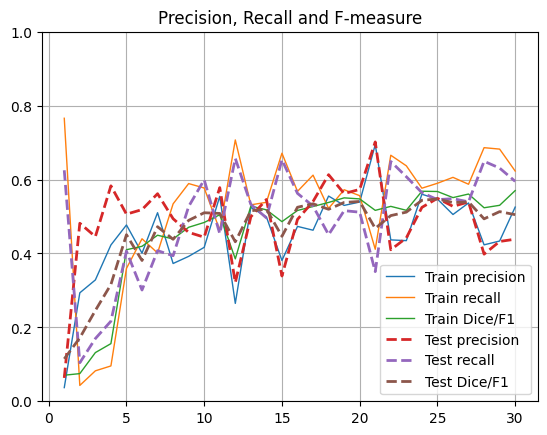

100%|████████████████████████████████████████| 30/30 [1:38:22<00:00, 196.75s/it]


pr_c, rec_c, f_meas, pr_nc, rec_nc
[np.float64(0.4384938266019976), np.float64(0.595014579176989), np.float64(0.5049019790228784), np.float64(0.9785330029252366), np.float64(0.9603621469692055)]
{'train_loss': np.float64(0.11571935564279556), 'train_accuracy': np.float64(98.01504717842116), 'train_nochange_accuracy': np.float64(98.78575134277344), 'train_change_accuracy': np.float64(62.29606628417969), 'test_loss': np.float64(0.24738407135009766), 'test_accuracy': np.float64(94.22957044304343), 'test_nochange_accuracy': np.float64(96.03620910644531), 'test_change_accuracy': np.float64(59.50145721435547)}
Elapsed time for training:
5902.431641340256
SAVE OK
LOAD OK


100%|███████████████████████████████████████████| 10/10 [00:33<00:00,  3.40s/it]

{'class_accuracy': [96.43497467041016, 57.7908821105957],
 'dice': np.float64(0.5178290294507798),
 'f_meas': np.float64(0.5178290294507798),
 'kappa': np.float64(0.48865364630476077),
 'net_accuracy': np.float64(94.43773359809951),
 'net_loss': 0.25392964482307434,
 'precision': np.float64(0.46906474820143884),
 'recall': np.float64(0.5779088114560873)}
Elapsed time for testing:
33.964487075805664


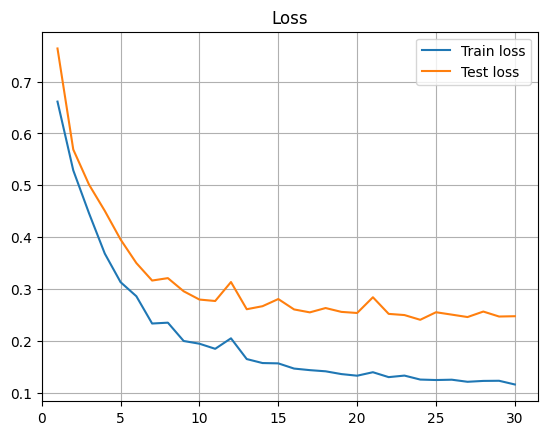

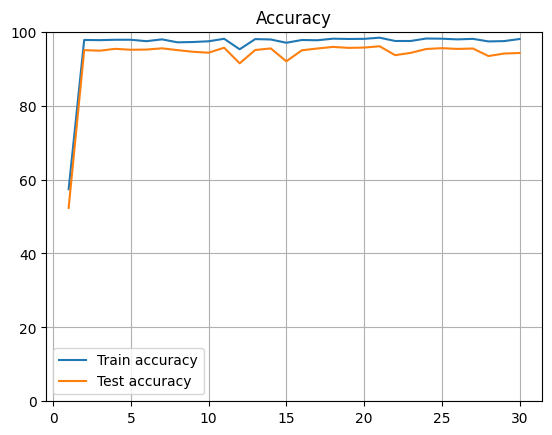

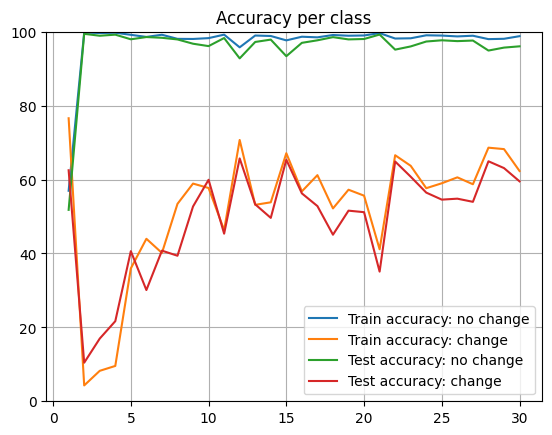

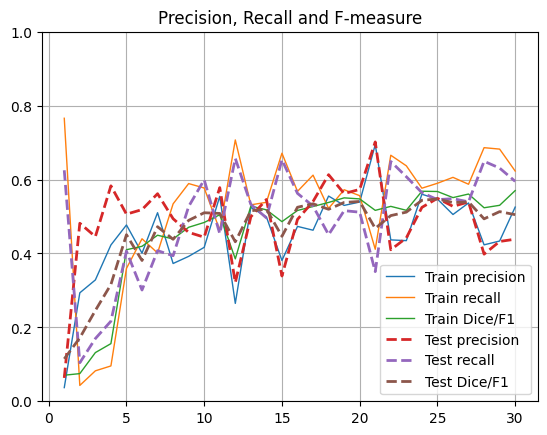

In [38]:
# LiRPA friendly encoder-decoder network training
netsota, netsota_name = EncDec_LiRPA(), 'EcnDec_LiRPA'
netsota.load_state_dict(torch.load('./final_net.pth.tar', weights_only=True), strict=False)
#print(netsota)
# for param in netsota.parameters():
#         param.requires_grad = False
# for name, module in netsota.named_modules():
#     #print(name)
#     if 'decres' in name:
#         for param in module.parameters():
#             param.requires_grad = True
#     if 'coupling' in name:
#             for param in module.parameters():
#                 param.requires_grad = True
# for name, param in netsota.named_parameters():
#         if param.requires_grad == True:
#             print(name)
netsota = netsota.to(device)
loss_fn = nn.CrossEntropyLoss(weight=dataset_weights)
netsota = netsota.to(device)
optimizer_netsota= torch.optim.Adam(netsota.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler_netsota = torch.optim.lr_scheduler.ExponentialLR(optimizer_netsota, 0.95)
print('LOAD OK')
t_start = time.time()
out_dic = train(netsota, netsota_name, loss_fn, optimizer_netsota, scheduler_netsota, feat=False)
t_end = time.time()
print(out_dic)
print('Elapsed time for training:')
print(t_end - t_start)
torch.save(netsota.state_dict(), 'verificationfriendly_FresUNet.pth.tar')
print('SAVE OK')

# Original SoTA network evaluation
netsota.load_state_dict(torch.load('verificationfriendly_FresUNet.pth.tar'))
netsota = netsota.to(device)
print('LOAD OK')
# Evaluate
t_start = time.time()
results = unseen_test_patch_batch(test_dataset, loss_fn, netsota, feat=False)
pprint(results)
t_end = time.time()
print('Elapsed time for testing:')
print(t_end - t_start)

In [14]:
# LiRPA friendly encoder-decoder evaluation
netsota.load_state_dict(torch.load('net-best_epoch-5_fm-0.6258941054068993.pth.tar'))
netsota = netsota.to(device)
print('LOAD OK')
# Evaluate
t_start = time.time()
results = unseen_test_patch_batch(test_dataset, loss_fn, netsota, feat=False)
pprint(results)
t_end = time.time()
print('Elapsed time for testing:')
print(t_end - t_start)

LOAD OK


100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.32s/it]

{'class_accuracy': [97.34835052490234, 58.8155403137207],
 'dice': np.float64(0.5669788538860796),
 'f_meas': np.float64(0.5669788538860796),
 'kappa': np.float64(0.5424815497879893),
 'net_accuracy': np.float64(95.35685602299723),
 'net_loss': 0.2873859405517578,
 'precision': np.float64(0.5472742161909219),
 'recall': np.float64(0.5881554215882875)}
Elapsed time for testing:
33.25184893608093


## LiRPA friendly Local Attention Encoder-decoder Falconet Architecture

In [23]:
# LiRPA friendly Local Attention Encoder-decoder Falconet Architecture   
class AttentionCondenser(nn.Module):
    """Lightweight attention using convolutions instead of full self-attention."""
    def __init__(self, d, reduction=8, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(d, d // reduction, kernel_size=1)
        self.conv2 = nn.Conv2d(d // reduction, d, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout2d(p=dropout)  # Dropout in attention

    def forward(self, x):
        attn = self.conv1(x)
        attn = self.conv2(attn)
        attn = self.dropout(attn)  # Dropout after attention layers
        return x * self.sigmoid(attn)


class ConvAttention(nn.Module):
    def __init__(self, hidden_dim, kernel_size=3, reduction_ratio=8):
        super().__init__()
        reduced_dim = hidden_dim // reduction_ratio

        # Downsample with depthwise conv (local feature extraction)
        self.depthwise_conv = nn.Conv1d(hidden_dim, hidden_dim, kernel_size, padding=kernel_size//2, groups=hidden_dim, bias=False)

        # Pointwise conv (lightweight attention projection)
        self.q_proj = nn.Conv1d(hidden_dim, reduced_dim, 1, bias=False)
        self.k_proj = nn.Conv1d(hidden_dim, reduced_dim, 1, bias=False)
        self.v_proj = nn.Conv1d(hidden_dim, hidden_dim, 1, bias=False)

        # Attention Scoring
        self.score_proj = nn.Conv1d(reduced_dim, hidden_dim, 1, bias=False)

        # Final pointwise conv
        self.out_proj = nn.Conv1d(hidden_dim, hidden_dim, 1, bias=False)

    def forward(self, x):
        """
        x: (batch, seq_len, hidden_dim)
        Output: (batch, seq_len, hidden_dim)
        """
        x = x.transpose(1, 2)  # (batch, hidden_dim, seq_len) for convs

        # Local feature extraction
        x_dw = self.depthwise_conv(x)

        # Query, Key, Value projection
        q = self.q_proj(x_dw)
        k = self.k_proj(x_dw)
        v = self.v_proj(x_dw)

        # Lightweight attention (sigmoid gating)
        attn_scores = self.score_proj(q * k).sigmoid()

        # Apply attention to values
        attn_output = attn_scores * v

        # Final projection
        out = self.out_proj(attn_output)

        # Residual connection
        out = out + x
        return out.transpose(1, 2)  # Back to (batch, seq_len, hidden_dim)


class MultiHeadConvAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads=2, kernel_size=3):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads  # Ensure correct head dim

        assert hidden_dim % num_heads == 0, \
            f"hidden_dim ({hidden_dim}) must be divisible by num_heads ({num_heads})"

        self.heads = nn.ModuleList([
            ConvAttention(self.head_dim, kernel_size) for _ in range(num_heads)
        ])
        self.out_proj = nn.Linear(hidden_dim, hidden_dim, bias=False)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.shape

        #print(f"embed_dim = {embed_dim}, num_heads * head_dim = {self.num_heads * self.head_dim}")  # Debug

        assert embed_dim == self.num_heads * self.head_dim, \
            f"Expected embedding dim {embed_dim} to match {self.num_heads * self.head_dim} (={self.num_heads * self.head_dim})"

        x = x.view(batch_size, seq_len, self.num_heads, self.head_dim)  
        x = x.permute(2, 0, 1, 3)  # (num_heads, batch, seq_len, head_dim)

        x = torch.stack([head(x[i]) for i, head in enumerate(self.heads)], dim=0)

        x = x.permute(1, 2, 0, 3).reshape(batch_size, seq_len, embed_dim)  # Merge heads
        return self.out_proj(x)

class FALCONetMHA_LiRPA(nn.Module):
    """FALCONetMHA_LiRPA segmentation network."""

 
class FALCONetMHA_LiRPA(nn.Module): 
    def __init__(self, in_channels=26, out_channels=2, dropout=0.1, reduction=8, attention=True, num_heads=4):
        """Init FALCONetMHA_LiRPA fields."""
        super(FALCONetMHA_LiRPA, self).__init__()
        self.dropout = dropout
        self.reduction = reduction
        self.attention = attention
        cur_depth = 8
        self.inc = DoubleConv(in_channels, cur_depth) 
        self.down1 = Down(cur_depth, cur_depth*2) 
        cur_depth *= 2

        self.down2 = Down(cur_depth, cur_depth*2) 
        cur_depth *= 2
        if self.attention:
            self.token_mixer_2 = MultiHeadConvAttention(cur_depth, num_heads=num_heads)
        self.down3 = Down(cur_depth, cur_depth*2) 
        cur_depth *= 2
        if self.attention:
            self.token_mixer_3 = MultiHeadConvAttention(cur_depth, num_heads=num_heads)
        self.down4 = Down(cur_depth, cur_depth*2) 
        cur_depth *= 2
        if self.attention:
            self.token_mixer_4 = MultiHeadConvAttention(cur_depth, num_heads=num_heads)
        self.up1 = Up(cur_depth, int(cur_depth/2)) 
        cur_depth = int(cur_depth/2)
        self.up2 = Up(cur_depth, int(cur_depth/2))
        cur_depth = int(cur_depth/2)
        self.up3 = Up(cur_depth, int(cur_depth/2))
        cur_depth = int(cur_depth/2)
        self.up4 = Up(cur_depth, int(cur_depth/2)) 
        cur_depth = int(cur_depth/2)
        self.outc = OutConv(cur_depth, out_channels)
 
    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        if self.attention:
            # Flatten spatial dimensions
            B, C, H, W = x3.shape
            N = H * W  # Number of tokens
            x3 = x3.view(B, C, N).transpose(1, 2)  # (B, N, C)
            
            # Apply Lightweight Convolutional Multi-Head Attention
            x3 = self.token_mixer_2(x3)  
            
            # Restore spatial shape
            x3 = x3.transpose(1, 2).view(B, C, H, W)  # Restore spatial shape
        x4 = self.down3(x3)
        if self.attention:
            # Flatten spatial dimensions
            B, C, H, W = x4.shape
            N = H * W  # Number of tokens
            x4 = x4.view(B, C, N).transpose(1, 2)  # (B, N, C)
            
            # Apply Lightweight Convolutional Multi-Head Attention
            x4 = self.token_mixer_3(x4)  
            
            # Restore spatial shape
            x4 = x4.transpose(1, 2).view(B, C, H, W)  # Restore spatial shape
        x5 = self.down4(x4)
        if self.attention:
            # Flatten spatial dimensions
            B, C, H, W = x5.shape
            N = H * W  # Number of tokens
            x5 = x5.view(B, C, N).transpose(1, 2)  # (B, N, C)
            
            # Apply Lightweight Convolutional Multi-Head Attention
            x5 = self.token_mixer_4(x5)  
            
            # Restore spatial shape
            x5 = x5.transpose(1, 2).view(B, C, H, W)  # Restore spatial shape
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Example usage
model, model_name = FALCONetMHA_LiRPA(2*13, 2 , dropout=0.1, reduction=8, attention=True, num_heads=4), 'FALCONetMHA_LiRPA'
#x = torch.randn(1, 13, 128, 128) 
x = torch.randn(1, 13, 256, 256)
out = model(x, x)
print(summary(model, input_size=(x.shape, x.shape)))

Layer (type:depth-idx)                   Output Shape              Param #
FALCONetMHA_LiRPA                        [1, 2, 256, 256]          --
├─DoubleConv: 1-1                        [1, 8, 256, 256]          --
│    └─Sequential: 2-1                   [1, 8, 256, 256]          --
│    │    └─Conv2d: 3-1                  [1, 8, 256, 256]          1,880
│    │    └─BatchNorm2d: 3-2             [1, 8, 256, 256]          16
│    │    └─ReLU: 3-3                    [1, 8, 256, 256]          --
│    │    └─Conv2d: 3-4                  [1, 8, 256, 256]          584
│    │    └─BatchNorm2d: 3-5             [1, 8, 256, 256]          16
│    │    └─ReLU: 3-6                    [1, 8, 256, 256]          --
├─Down: 1-2                              [1, 16, 128, 128]         --
│    └─Sequential: 2-2                   [1, 16, 128, 128]         --
│    │    └─Conv2d: 3-7                  [1, 16, 128, 128]         1,168
│    │    └─BatchNorm2d: 3-8             [1, 16, 128, 128]         32
│    │  

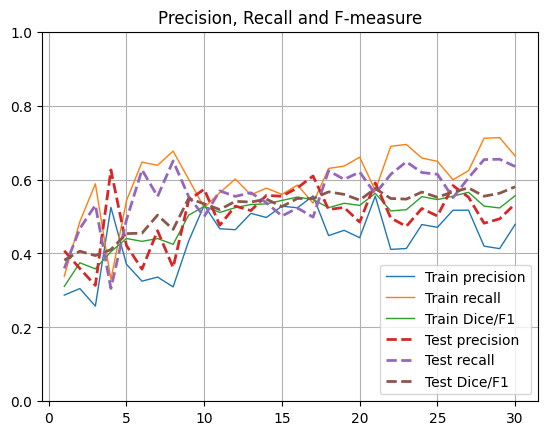

100%|████████████████████████████████████████| 30/30 [1:23:42<00:00, 167.43s/it]


pr_c, rec_c, f_meas, pr_nc, rec_nc
[np.float64(0.5343706310473683), np.float64(0.6351785675136474), np.float64(0.5804300877084027), np.float64(0.9808329620621515), np.float64(0.971207121588078)]
{'train_loss': np.float64(0.10721006989479065), 'train_accuracy': np.float64(97.76308018668058), 'train_nochange_accuracy': np.float64(98.4405288696289), 'train_change_accuracy': np.float64(66.36599731445312), 'test_loss': np.float64(0.2222418189048767), 'test_accuracy': np.float64(95.45905047038929), 'test_nochange_accuracy': np.float64(97.12071228027344), 'test_change_accuracy': np.float64(63.51785659790039)}
Elapsed time for training:
5022.953227043152
SAVE OK
LOAD OK


100%|███████████████████████████████████████████| 10/10 [00:31<00:00,  3.13s/it]

{'class_accuracy': [97.22432708740234, 62.975791931152344],
 'dice': np.float64(0.5888178679009624),
 'f_meas': np.float64(0.5888178679009624),
 'kappa': np.float64(0.5648668876441632),
 'net_accuracy': np.float64(95.45425895795104),
 'net_loss': 0.23221303522586823,
 'precision': np.float64(0.5528758595569487),
 'recall': np.float64(0.629757915977797)}
Elapsed time for testing:
31.319353342056274


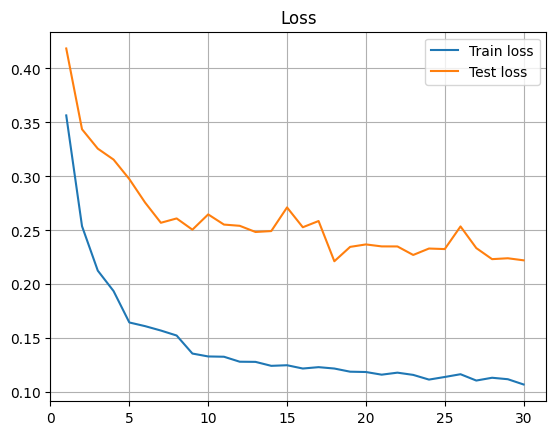

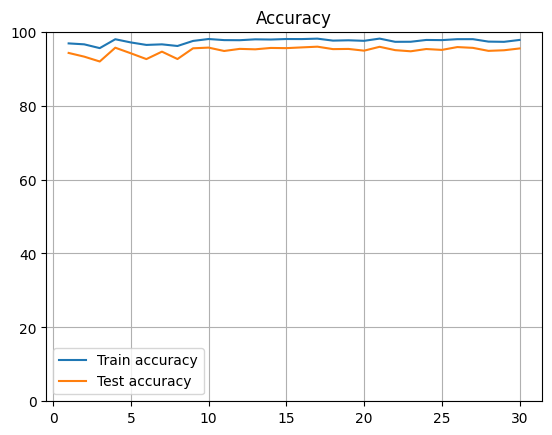

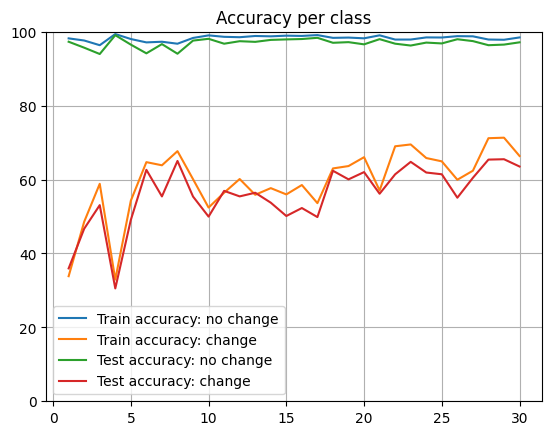

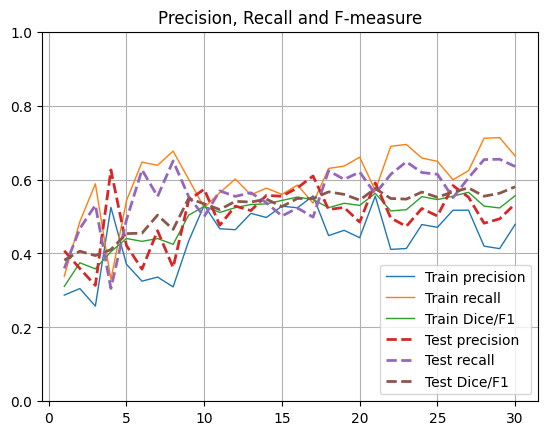

In [25]:
# FALCONetMHA Finetuning
falconet_retrained, falconet_retrained_name = FALCONetMHA_LiRPA(2*13, 2 , dropout=0.1, reduction=8, attention=True, num_heads=4), 'FALCONetMHA_LiRPA'

falconet_retrained.load_state_dict(torch.load('./FALCONetMHA_Balance.pth.tar', weights_only=True), strict=False)
falconet_retrained = falconet_retrained.to(device)
loss_fn = nn.CrossEntropyLoss(weight=dataset_weights)
optimizer_falconet_retrained = torch.optim.Adam(falconet_retrained.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler_falconet_retrained = torch.optim.lr_scheduler.ExponentialLR(optimizer_falconet_retrained, 0.95)
print('LOAD OK')
t_start = time.time()
out_dic = train(falconet_retrained, falconet_retrained_name, loss_fn, optimizer_falconet_retrained, scheduler_falconet_retrained, feat=False)
t_end = time.time()
print(out_dic)
print('Elapsed time for training:')
print(t_end - t_start)
torch.save(falconet_retrained.state_dict(), 'FALCONetMHA_LiRPA.pth.tar')
print('SAVE OK')

# Original SoTA network evaluation
falconet_retrained.load_state_dict(torch.load('FALCONetMHA_LiRPA.pth.tar'))
falconet_retrained = falconet_retrained.to(device)
print('LOAD OK')
# Evaluate
t_start = time.time()
results = unseen_test_patch_batch(test_dataset, loss_fn, falconet_retrained, feat=False)
pprint(results)
t_end = time.time()
print('Elapsed time for testing:')
print(t_end - t_start)

In [28]:
# testing the best model
falconet_retrained.load_state_dict(torch.load('net-best_epoch-27_loss-0.1108483299612999.pth.tar'))
falconet_retrained = falconet_retrained.to(device)
print('LOAD OK')
# Evaluate
t_start = time.time()
results = unseen_test_patch_batch(test_dataset, loss_fn, falconet_retrained, feat=False)
pprint(results)
t_end = time.time()
print('Elapsed time for testing:')
print(t_end - t_start)

LOAD OK


100%|███████████████████████████████████████████| 10/10 [00:29<00:00,  2.94s/it]

{'class_accuracy': [97.64736938476562, 59.133628845214844],
 'dice': np.float64(0.5846091698646738),
 'f_meas': np.float64(0.5846091698646738),
 'kappa': np.float64(0.5616987413806527),
 'net_accuracy': np.float64(95.6568622609437),
 'net_loss': 0.2449558526277542,
 'precision': np.float64(0.5780334033845813),
 'recall': np.float64(0.5913362711139888)}
Elapsed time for testing:
29.433314561843872


In [8]:
save_test_results(falconet_retrained, test_dataset, falconet_retrained_name, feat=True)

100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.99it/s]


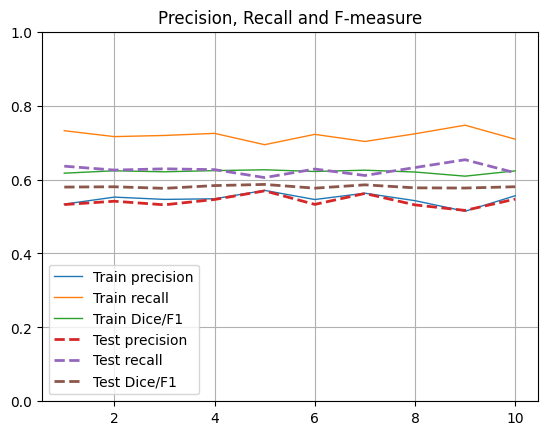

100%|████████████████████████████████████████████████████████████████████| 10/10 [24:11<00:00, 145.12s/it]


pr_c, rec_c, f_meas, pr_nc, rec_nc
[np.float64(0.5469753680335026), np.float64(0.6182540530686397), np.float64(0.5804346029909939), np.float64(0.9790461363176035), np.float64(0.9720928623136643)]
{'train_loss': np.float64(0.09550242125988007), 'train_accuracy': np.float64(98.03115513155348), 'train_nochange_accuracy': np.float64(98.6689682006836), 'train_change_accuracy': np.float64(70.90912628173828), 'test_loss': np.float64(0.2563418745994568), 'test_accuracy': np.float64(95.380540725993), 'test_nochange_accuracy': np.float64(97.20928192138672), 'test_change_accuracy': np.float64(61.82540512084961)}
Elapsed time for training:
1451.2224957942963
SAVE OK


100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.68s/it]

{'class_accuracy': [97.20928192138672, 61.82540512084961],
 'dice': np.float64(0.5804346029909939),
 'f_meas': np.float64(0.5804346029909939),
 'kappa': np.float64(0.5560884837390216),
 'net_accuracy': np.float64(95.380540725993),
 'net_loss': 0.2563418745994568,
 'precision': np.float64(0.5469753680335026),
 'recall': np.float64(0.6182540530686397)}
Elapsed time for testing:
36.88215398788452


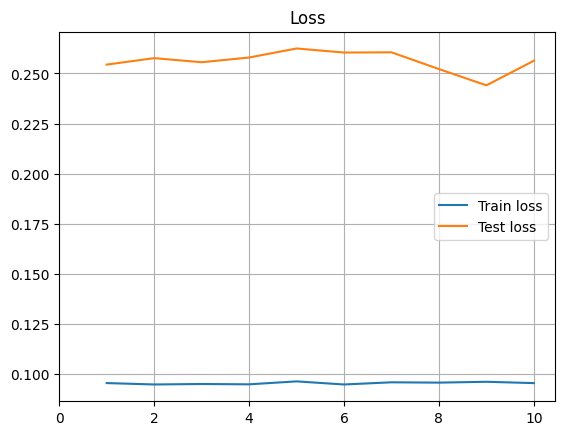

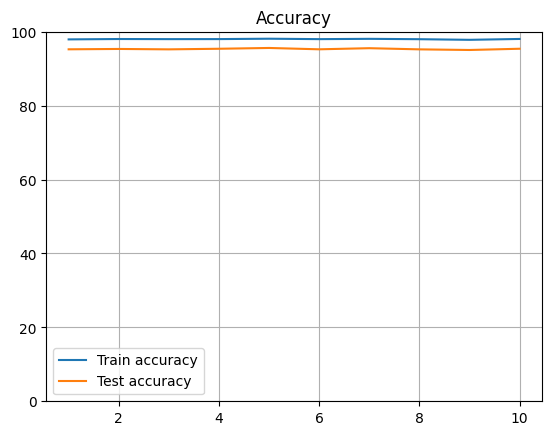

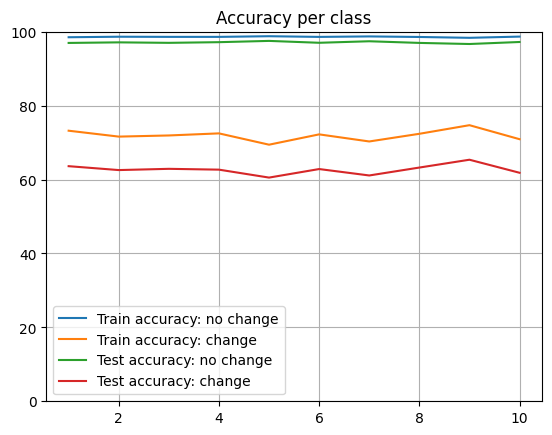

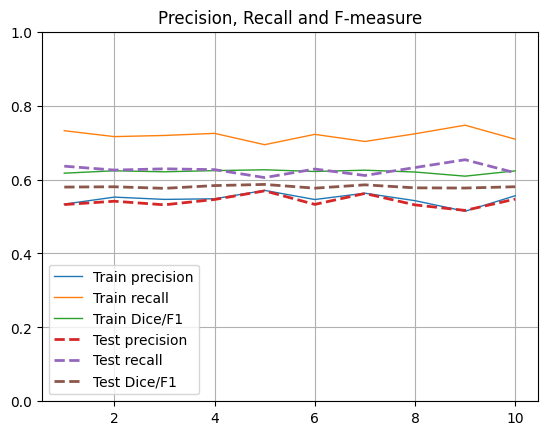

In [8]:
# # Predistilled FALCONetMHA Finetuning

# pd_student_model = FALCONetMHA(2*13, 2, base_depth=8, encoding_level=4, depth_multiplier=2, subsampler=2, reduction=8, dropout=0.1)
# pd_student_model_name = 'predistilled_falconet_balance'
# pd_student_model.load_state_dict(torch.load('./predistilled_falconet_balance.pth.tar', weights_only=True), strict=False)
# for param in pd_student_model.parameters():
#         param.requires_grad = False
# for param in pd_student_model.coupling.parameters():
#         param.requires_grad = True
# pd_student_model = pd_student_model.to(device)
# print('LOAD OK')
# loss_fn = nn.CrossEntropyLoss(weight=dataset_weights)
# optimizer = torch.optim.Adam(falconet_retrained.parameters(), lr=5e-4, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
# t_start = time.time()
# out_dic = train_batch(pd_student_model, pd_student_model_name, loss_fn, optimizer, scheduler, feat=True)
# t_end = time.time()
# print(out_dic)
# print('Elapsed time for training:')
# print(t_end - t_start)
# torch.save(pd_student_model.state_dict(), 'verificatiofriendly_predistilled_falconet_finetune.pth.tar')
# print('SAVE OK')
# t_start = time.time()
# pd_student_model.load_state_dict(torch.load('./verificatiofriendly_predistilled_falconet_finetune.pth.tar', weights_only=True), strict=False)
# pd_student_model = pd_student_model.to(device)

# results = unseen_test_patch_batch(test_dataset, loss_fn, pd_student_model, feat=True)
# pprint(results)
# t_end = time.time()
# print('Elapsed time for testing:')
# print(t_end - t_start)

In [16]:
# Attunet definition
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1
        
class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1


class single_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(single_conv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi



class AttU_Net(nn.Module):
    def __init__(self,img_ch=26,output_ch=1):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)
        self.sm = nn.Identity()


    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)
        
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return self.sm(d1)

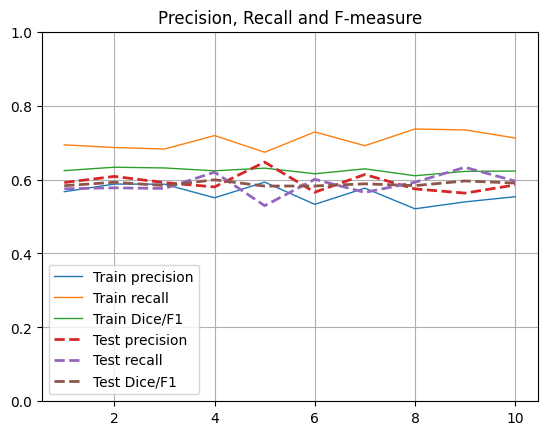

100%|██████████████████████████████████████████████████████████████████| 10/10 [1:03:40<00:00, 382.09s/it]


pr_c, rec_c, f_meas, pr_nc, rec_nc
[np.float64(0.5853435548334888), np.float64(0.5956612206667211), np.float64(0.5904573184030308), np.float64(0.977942459933026), np.float64(0.9770030001449196)]
{'train_loss': np.float64(0.09712174534797668), 'train_accuracy': np.float64(98.01855842768586), 'train_nochange_accuracy': np.float64(98.6484146118164), 'train_change_accuracy': np.float64(71.2350082397461), 'test_loss': np.float64(0.26409104466438293), 'test_accuracy': np.float64(95.72941087793899), 'test_nochange_accuracy': np.float64(97.70030212402344), 'test_change_accuracy': np.float64(59.566123962402344)}
Elapsed time for training:
3820.9489755630493
SAVE OK


100%|█████████████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.95s/it]

{'class_accuracy': [97.70030212402344, 59.566123962402344],
 'dice': np.float64(0.5904573184030308),
 'f_meas': np.float64(0.5904573184030308),
 'kappa': np.float64(0.5679316366628507),
 'net_accuracy': np.float64(95.72941087793899),
 'net_loss': 0.26409104466438293,
 'precision': np.float64(0.5853435548334888),
 'recall': np.float64(0.5956612206667211)}
Elapsed time for testing:
69.61142802238464


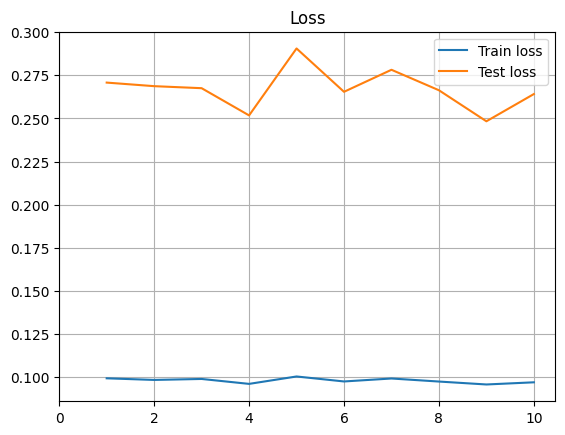

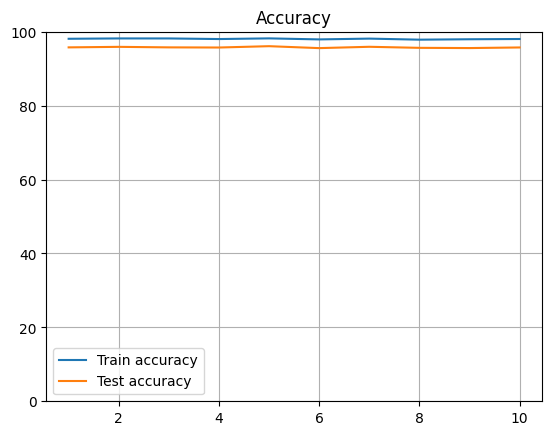

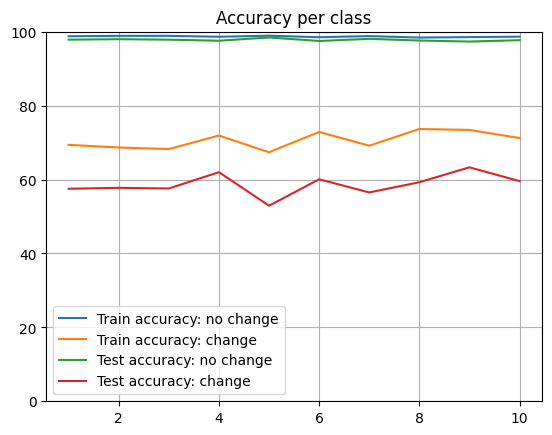

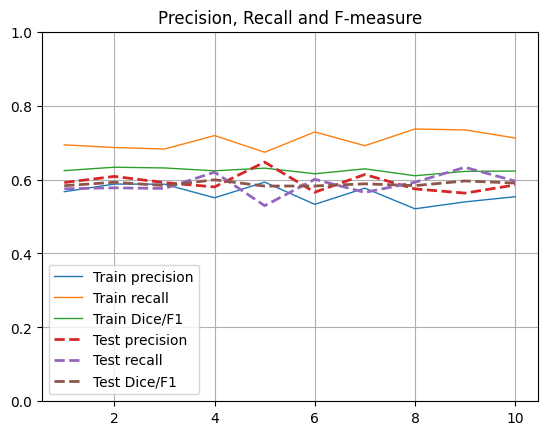

In [19]:
saved_aunet, saved_aunet_name = AttU_Net(2*13, 2), 'AttU_Net'
loss_fn = nn.CrossEntropyLoss(weight=dataset_weights)
saved_aunet.load_state_dict(torch.load('attunet_25epc.pth.tar', weights_only=True), strict=False)
for param in saved_aunet.parameters():
        param.requires_grad = False
for param in saved_aunet.Conv_1x1.parameters():
        param.requires_grad = True
saved_aunet = saved_aunet.to(device)
print('LOAD OK')
loss_fn = nn.CrossEntropyLoss(weight=dataset_weights)
optimizer = torch.optim.Adam(saved_aunet.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
t_start = time.time()
out_dic = train_batch(saved_aunet, saved_aunet_name, loss_fn, optimizer, scheduler, feat=False)
t_end = time.time()
print(out_dic)
print('Elapsed time for training:')
print(t_end - t_start)
torch.save(saved_aunet.state_dict(), 'verificatiofriendly_attunet_finetune.pth.tar')
print('SAVE OK')
t_start = time.time()
saved_aunet.load_state_dict(torch.load('./verificatiofriendly_attunet_finetune.pth.tar', weights_only=True), strict=False)
saved_aunet = saved_aunet.to(device)

results = unseen_test_patch_batch(test_dataset, loss_fn, saved_aunet, feat=False)
pprint(results)
t_end = time.time()
print('Elapsed time for testing:')
print(t_end - t_start)